In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm

TRAIN = True

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))])

trainset = torchvision.datasets.MNIST(root='./data', 
                                        train=True,
                                        download=True,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                            batch_size=100,
                                            shuffle=True,
                                            num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', 
                                        train=False, 
                                        download=True, 
                                        transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=100,
                                            shuffle=False, 
                                            num_workers=2)

classes = tuple(np.linspace(0, 9, 10, dtype=np.uint8))

In [2]:
raw_y = np.array([int(y) for y in trainset.targets])
raw_x = np.array([y for y in trainset.data.numpy()])

In [3]:
idx = trainset.train_labels==1
trainset.targets = trainset.targets[idx]
trainset.data = trainset.data[idx]

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [4]:
idx = testset.train_labels==6
testset.targets = testset.targets[idx]
testset.data = testset.data[idx]

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


set dataloader

In [5]:
trainloader = torch.utils.data.DataLoader(trainset,
                                            batch_size=100,
                                            shuffle=True,
                                            num_workers=2)
testloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=100,
                                            shuffle=False, 
                                            num_workers=2)

In [6]:
testset = torchvision.datasets.MNIST(root='./data', 
                                        train=False, 
                                        download=True, 
                                        transform=transform)
idx = testset.train_labels==1
testset.targets = testset.targets[idx]
testset.data = testset.data[idx]
testloader1 = torch.utils.data.DataLoader(testset, 
                                            batch_size=100,
                                            shuffle=False, 
                                            num_workers=2)


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


## define model

In [7]:
import pretrainedmodels
model_name = "resnet18"
basemodel = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
basemodel = nn.Sequential(*list(basemodel.children())[1:-2])

In [8]:
from metrics import ArcMarginProduct
class mymodel(nn.Module):
    def __init__(self):
        super(mymodel, self).__init__()
        self.features = basemodel
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1, bias=False)
        if model_name == "resnet34" or model_name == "resnet18":
            num_ch = 512
        else:
            num_ch = 2048
        # vowel_diacritic       
        self.fc1 = nn.Conv2d(num_ch, 1, 1)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        
    def forward(self, x):
        # extract features
        x = self.conv1(x)
        x = self.features(x)
        x = self.avgpool(x).squeeze(2).squeeze(2)

        #x1 = self.arcface(x).squeeze(2).squeeze(2)
        
        return x

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
#model2 = mymodel()
#input = torch.rand(10,1,28,28)
#model2(input).size()

In [10]:
model = mymodel()
model = model.to(device)

# define arcface

In [11]:
metric_fc = ArcMarginProduct(512, 2, s=100, m=1, easy_margin=False).to(device)

In [12]:
optimizer = torch.optim.Adam([{'params': model.parameters()}, {'params': metric_fc.parameters()}],
                                     lr=1e-4, weight_decay=1e-4)

In [13]:
criterion = torch.nn.CrossEntropyLoss()

## train script

In [14]:
def train(epoch):
    model.train()
    print('epochs {}/{} '.format(epoch+1,epochs))
    running_loss = 0.0
    running_acc = 0.0
    acc1 = 0.0
    acc2 = 0.0
    acc3 = 0.0
    t = tqdm(trainloader)
    
    for idx, (inputs,labels1) in enumerate(t):       
        # send to gpu
        inputs = inputs.to(device)
        labels1 = torch.zeros(inputs.size()[0]).to(device).long() #.unsqueeze(1)
        
        # set opt
        optimizer.zero_grad()
        
        # run model
        feat = model(inputs.float())
        outputs = metric_fc(feat, labels1)
        #print(feat.size())
        #print(labels1.size())
        #print(outputs.size())
        loss = criterion(outputs,labels1)
        #running_loss += loss
        
        loss.backward()
        optimizer.step()
        
        if idx%8==7:
            print(loss.item())
        

In [15]:
def eval(epoch):
    model.eval()
    print('epochs {}/{} '.format(epoch+1,epochs))
    running_loss = 0.0
    running_acc = 0.0
    acc1 = 0.0
    acc2 = 0.0
    acc3 = 0.0
    t = tqdm(testloader)
    
    for idx, (inputs,labels1) in enumerate(t):       
        # send to gpu
        inputs = inputs.to(device)
        labels1 = torch.zeros(inputs.size()[0]).to(device).long()+1 #.unsqueeze(1)
        
        # set opt
        optimizer.zero_grad()
        
        # run model
        feat = model(inputs.float())
        outputs = metric_fc(feat, labels1)
        print(outputs)
        #print(feat.size())
        #print(labels1.size())
        #print(outputs.size())
        loss = criterion(outputs,labels1)
        #running_loss += loss
        
        #loss.backward()
        #optimizer.step()
        
        if idx%8==7:
            print(loss.item())
        

In [16]:
def eval2(epoch):
    model.eval()
    print('epochs {}/{} '.format(epoch+1,epochs))
    running_loss = 0.0
    running_acc = 0.0
    acc1 = 0.0
    acc2 = 0.0
    acc3 = 0.0
    t = tqdm(trainloader)
    
    for idx, (inputs,labels1) in enumerate(t):       
        # send to gpu
        inputs = inputs.to(device)
        labels1 = torch.zeros(inputs.size()[0]).to(device).long() #.unsqueeze(1)
        
        # set opt
        optimizer.zero_grad()
        
        # run model
        feat = model(inputs.float())
        outputs = metric_fc(feat, labels1)
        print(outputs)
        #print(feat.size())
        #print(labels1.size())
        #print(outputs.size())
        loss = criterion(outputs,labels1)
        #running_loss += loss
        
        #loss.backward()
        #optimizer.step()
        
        if idx%8==7:
            print(loss.item())
        

In [17]:
epochs = 10
if TRAIN:
    for epoch in range(epochs):
        train(epoch)
        torch.save(model.state_dict(), './saved_weights.pth')
else:
    model.load_state_dict(torch.load('./saved_weights.pth'))

epochs 1/10 


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


37.218505859375
12.988600730895996
12.543526649475098
8.28161334991455
22.47705841064453
8.636274337768555
5.372640609741211
11.07989501953125

epochs 2/10 


7.049687385559082
4.281862258911133
7.984755039215088
7.225332736968994
5.340043544769287
4.801694869995117
3.477311372756958
4.158641815185547

epochs 3/10 


3.825239896774292
2.182143449783325
3.907597541809082
5.531564712524414
3.215028762817383
7.049904823303223
4.223404407501221
3.025188684463501

epochs 4/10 


2.9720473289489746
4.748741149902344
3.114020347595215
1.8444912433624268
3.019777536392212
1.6352595090866089
2.7559828758239746
1.9991613626480103

epochs 5/10 


1.6718138456344604
1.6229711771011353
2.6321113109588623
1.4067399501800537
1.9529463052749634
1.4597058296203613
2.95658802986145
1.049586534500122

epochs 6/10 


1.9666311740875244
2.255652666091919
2.7168288230895996
1.6974689960479736
1.2944004535675049
2.579429864883423
0.9750233292579651
1.784542441368103

epochs 7/10 


0.957261323928833
3.7591400146484375
1.0852006673812866
1.6490166187286377
0.9999572038650513
0.908118724822998
1.4996414184570312
1.6768677234649658

epochs 8/10 


1.1483581066131592
0.8792452216148376
0.8901730179786682
0.8723612427711487
1.5727992057800293
1.5279109477996826
0.853116512298584
1.242124080657959

epochs 9/10 


0.8478714227676392
0.8527267575263977
0.8368944525718689
0.8323028683662415
0.936122715473175
0.803931474685669
0.8577055335044861
2.2620322704315186

epochs 10/10 


0.8354017734527588
1.7299935817718506
0.8172147870063782
1.6101702451705933
0.8276569247245789
1.8527973890304565
0.7798843383789062
1.3163845539093018



In [18]:
def cosin_metric(x1, x2):
    return np.dot(x1, x2)# / (np.linalg.norm(x1) * np.linalg.norm(x2))

In [19]:
model.eval()
with torch.no_grad():
    train = trainset[0][0]
    out1 = model(train.unsqueeze(0).to(device)).cpu().numpy()
    test = testset[0][0]
    out2 = model(test.unsqueeze(0).to(device)).cpu().numpy()

print("different number:", cosin_metric(out1, out2.T))


different number: [[28.850058]]


In [20]:
with torch.no_grad():
    train = trainset[0][0]
    out1 = model(train.unsqueeze(0).to(device)).cpu().numpy()
    test = trainset[2][0]
    out2 = model(test.unsqueeze(0).to(device)).cpu().numpy()
    
print("same number:", cosin_metric(out1, out2.T))

same number: [[28.90596]]


In [21]:
torch.cuda.empty_cache()

## inference and evaluate distance.

In [22]:
t = tqdm(trainloader)  
for idx, (inputs,labels1) in enumerate(t):       
    # send to gpu
    inputs = inputs.to(device)
    labels1 = torch.zeros(inputs.size()[0]).to(device).long() #.unsqueeze(1)
    # run model
    with torch.no_grad():
        out = model(inputs.float())
    if idx  == 0:
        outs = out
    else:
        outs = torch.cat((outs, out))

normals = outs.cpu().numpy()

t = tqdm(testloader1)  
for idx, (inputs,labels1) in enumerate(t):       
    # send to gpu
    inputs = inputs.to(device)
    labels1 = torch.zeros(inputs.size()[0]).to(device).long() #.unsqueeze(1)
    # run model
    with torch.no_grad():
        out = model(inputs.float())
    if idx  == 0:
        outs = out
    else:
        outs = torch.cat((outs, out))

normals1 = outs.cpu().numpy()

t = tqdm(testloader)  
for idx, (inputs,labels1) in enumerate(t):       
    # send to gpu
    inputs = inputs.to(device)
    labels1 = torch.zeros(inputs.size()[0]).to(device).long() #.unsqueeze(1)
    # run model
    with torch.no_grad():
        out = model(inputs.float())
    if idx  == 0:
        outs = out
    else:
        outs = torch.cat((outs, out))
        
abnormals = outs.cpu().numpy()

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [23]:
print(normals.shape)
print(abnormals.shape)

(6742, 512)
(958, 512)


In [24]:
same = np.clip(np.mean(cosin_metric(normals, normals1.T), axis=0), 0, 100)
same.shape

(1135,)

In [25]:
different = np.clip(np.mean(cosin_metric(normals, abnormals.T), axis=0), 0, 100)
different.shape

(958,)

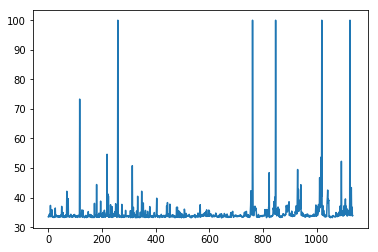

In [30]:
# print scatter plot of same 1s
import matplotlib.pyplot as plt
plt.plot(same)

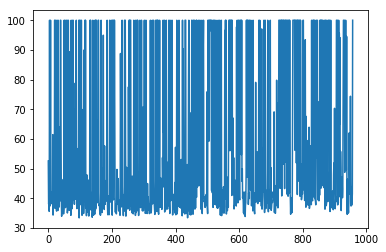

In [27]:
plt.plot(different)

In [35]:
np.sum(different>=35)

903

In [36]:
np.sum(same>=35)

186

In [39]:
predict_y = np.concatenate([same, different])
samelabel = np.zeros_like(same)
diflabel = np.ones_like(different)
test_y = np.concatenate([samelabel, diflabel])

In [40]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

# FPR, TPR(, しきい値) を算出
fpr, tpr, thresholds = metrics.roc_curve(test_y, predict_y)

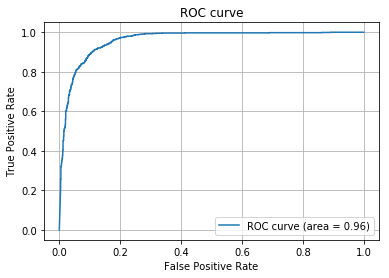

In [41]:
# ついでにAUCも
auc = metrics.auc(fpr, tpr)

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)